# Tutorial 2 (JAX): Introduction to JAX+Flax

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.ipynb)   
**Author:** Phillip Lippe

Welcome to our JAX tutorial for the Deep Learning course at the University of Amsterdam! The following notebook is meant to give a short introduction to JAX, including writing and training your own neural networks with [Flax](https://flax.readthedocs.io/en/latest/). But why should you learn JAX, if there are already so many other deep learning frameworks like [PyTorch](https://pytorch.org/) and [TensorFlow](https://www.tensorflow.org/)? The short answer: because it can be extremely fast. For instance, a small GoogleNet on CIFAR10, which we discuss in detail in [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html), can be trained in JAX 3x faster than in PyTorch with a similar setup. Note that for larger models, larger batch sizes, or smaller GPUs, a considerably smaller speedup is expected, and the code has not been designed for benchmarking. Nonetheless, JAX enables this speedup by compiling functions and numerical programs for accelerators (GPU/TPU) *just in time*, finding the optimal utilization of the hardware. Frameworks with dynamic computation graphs like PyTorch cannot achieve the same efficiency, since they cannot anticipate the next operations before the user calls them. For example, in an Inception block of GoogleNet, we apply multiple convolutional layers in parallel on the same input. JAX can optimize the execution of this layer by compiling the whole forward pass for the available accelerator and fusing operations where possible, reducing memory access and speeding up execution. In contrast, when calling the first convolutional layer in PyTorch, the framework does not know that multiple convolutions on the same feature map will follow. It sends each operation one by one to the GPU, and can only adapt the execution after seeing the next Python calls. Hence, JAX can make more efficient use of the GPU than, for instance, PyTorch.

However, everything comes with a price. In order to efficiently compile programs just-in-time in JAX, the functions need to be written with certain constraints. Firstly, the functions are not allowed to have side-effects, meaning that they are not allowed to affect any variable outside of their namespaces. For instance, in-place operations affect a variable even outside of the function. Moreover, stochastic operations such as `torch.rand(...)` change the global state of pseudo random number generators, which is not allowed in functional JAX (we will see later how JAX handles random number generation). Secondly, JAX compiles the functions based on anticipated shapes of all arrays/tensors in the function. This becomes problematic if the shapes or the program flow within the function depends on the values of the tensor. For instance, in the operation `y = x[x>3]`, the shape of `y` depends on how many values of `x` are greater than 3. We will discuss more of these constraints in this notebook. Still, in most common cases of training neural networks, it is straightforward to write functions within these constraints.

This tutorial is heavily inspired by many great JAX tutorials before, and a (non-exclusive) list of them are:

* [JAX 101](https://jax.readthedocs.io/en/latest/jax-101/index.html) with many subtutorials on individual parts of JAX
* [JAX - The Sharp Bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) discusses the constraints of JAX and how to overcome them
* [Jax for the Impatient](https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html) for a quick intro to JAX with focus on deep learning
* [Flax Basics](https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html) as introduction to the Flax framework

Throughout this tutorial, we will draw comparisons to PyTorch and also use its data loading library (see our [PyTorch tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html) for a refresher). JAX is not meant to 'redefine the wheel', so we can combine it framework-agnostic parts from PyTorch (e.g., data loading) and TensorFlow (e.g., logging in TensorBoard). Further, we use [Flax](https://flax.readthedocs.io/en/latest/) as a neural network library in JAX, and [Optax](https://optax.readthedocs.io/en/latest/index.html) to implement common deep learning optimizers. More on them later in the notebook. First, let's get started with some basic JAX operations.

In [9]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

/tmp/ipython-input-9-3573019839.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


## JAX as NumPy on accelerators

Every deep learning framework has its own API for dealing with data arrays. For example, PyTorch uses `torch.Tensor` as data arrays on which it defines several operations like matrix multiplication, taking the mean of the elements, etc. In JAX, this basic API strongly resembles the one of [NumPy](https://numpy.org/), and even has the same name in JAX (`jax.numpy`). So, for now, let's think of JAX as NumPy that runs on accelerators. As a first step, let's import JAX and its NumPy API:

In [10]:
import jax
import jax.numpy as jnp
print("Using jax", jax.__version__)

Using jax 0.5.2


At the current time of writing (June 2022), the newest JAX version is `0.3.13` which supports most of the common NumPy functionalities. The NumPy API of JAX is usually imported as `jnp`, to keep a resemblance to NumPy's import as `np`. In the following subsections, we will discuss the main differences between the classical NumPy API and the one of JAX.

### Device Arrays

As a first test, let's create some arbitrary arrays like we would do in NumPy. For instance, let's create an array of zeros with shape `[2,5]`:

In [11]:
a = jnp.zeros((2, 5), dtype=jnp.float32)
print(a)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


Similarly, we can create an array with values of 0 to 5 by using `arange`:

In [12]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


You might now wonder whether the arrays `a` and `b` are simply NumPy arrays. To check that, let's print out the class of `b`:

In [13]:
b.__class__

jaxlib.xla_extension.ArrayImpl

Instead of a simple NumPy array, it shows the type `DeviceArray` which is what JAX uses to represent arrays. In contrast to NumPy, JAX can execute the same code on different backends – CPU, GPU and TPU. A `DeviceArray` therefore represents an array which is on one of the backends. Similar to PyTorch, we can check the device of an array by calling `.device()`:

In [14]:
b.devices()

{CudaDevice(id=0)}

As you can see, the array `b` is already natively on a GPU although we did not specify this explicitly as you would do in PyTorch (on Colab, remember to select a GPU in your runtime environment). In order to change the device of an array, we can use `jax.device_get`:

In [15]:
b_cpu = jax.device_get(b)
print(b_cpu.__class__)

<class 'numpy.ndarray'>


Unsurprisingly, a simple CPU-based array is nothing else than a NumPy array, which allows for a simple conversion between the two frameworks! To explicitly push a NumPy array to the accelerator, you can use `jax.device_put`:

In [16]:
b_gpu = jax.device_put(b_cpu)
print(f'Device put: {b_gpu.__class__} on {b_gpu.devices()}')

Device put: <class 'jaxlib.xla_extension.ArrayImpl'> on {CudaDevice(id=0)}


Nicely enough, JAX will handle any device clash itself when you try to perform operations on a NumPy array and a DeviceArray by modeling the output as DeviceArray again:

In [17]:
b_cpu + b_gpu

Array([ 0,  2,  4,  6,  8, 10], dtype=int32)

Finally, we can also print all our available devices using `jax.devices()`:

In [18]:
jax.devices()

[CudaDevice(id=0)]

A technical detail of running operations on DeviceArrays is that when a JAX function is called, the corresponding operation takes place asynchronously on the accelerator when possible. For instance, if we call `out = jnp.matmul(b, b)`, JAX first returns a placeholder array for `out` which may not be filled with the values as soon as the function calls finishes. This way, Python will not block the execution of follow-up statements, but instead only does it whenever we strictly need the value of `out`, for instance for printing or putting it on CPU. PyTorch uses a very similar principle to allow asynchronous computation. For more details, see [JAX - Asynchronous Dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html).

### Immutable tensors

When we would like to change a NumPy array in-place, like replacing the first element of `b` with `1` instead of `0`, we could simply write `b[0]=1`. However, in JAX, this is not possible. A `DeviceArray` object is *immutable*, which means that no in-place operations are possible. The reason for this goes back to our discussion in the introduction: JAX requires programs to be "pure" functions, i.e. no effects on variables outside of the function are allowed. Allowing in-place operations of variables would make the program analysis for JAX's just-in-time compilation difficult. Instead, we can use the expression `b.at[0].set(1)` which, analogous to the in-place operation, returns a new array which is identical to `b`, except that its value at the first position is 1. Let's try that out below:

In [19]:
b_new = b.at[0].set(1)
print('Original array:', b)
print('Changed array:', b_new)

Original array: [0 1 2 3 4 5]
Changed array: [1 1 2 3 4 5]


However, we said that JAX is very efficient. Isn't creating a new array in this case the opposite? While it is indeed less efficient, it can made much more efficient with JAX's just-in-time compilation. The compiler can recognize unnecessary array duplications, and replace them with in-place operations again. More on the just-in-time compilation later!

### Pseudo Random Numbers in JAX

In machine learning, we come across several situations where we need to generate pseudo random numbers: randomly shuffling a dataset, sampling a dropout mask for regularization, training a VAE by sampling from the approximate posterior, etc. In libraries like NumPy and PyTorch, the random number generator are controlled by a seed, which we set initially to obtain the same samples every time we run the code (this is why the numbers are not truly random, hence "pseudo"-random). However, if we call `np.random.normal()` 5 times consecutively, we will get 5 different numbers since every execution changes the state/seed of the pseudo random number generation (PRNG). In JAX, if we would try to generate a random number with this approach, a function creating pseudo-random number would have an effect outside of it. To prevent this, JAX takes a different approach by explicitly passing and iterating the PRNG state. First, let's create a PRNG for the seed 42:

In [20]:
rng = jax.random.PRNGKey(42)

Now, we can use this PRNG state to generate random numbers. Since with this state, the random number generation becomes deterministic, we sample the same number every time. This is not the case in NumPy if we set the seed once before both operations:

In [21]:
# A non-desirable way of generating pseudo-random numbers...
jax_random_number_1 = jax.random.normal(rng)
jax_random_number_2 = jax.random.normal(rng)
print('JAX - Random number 1:', jax_random_number_1)
print('JAX - Random number 2:', jax_random_number_2)

# Typical random numbers in NumPy
np.random.seed(42)
np_random_number_1 = np.random.normal()
np_random_number_2 = np.random.normal()
print('NumPy - Random number 1:', np_random_number_1)
print('NumPy - Random number 2:', np_random_number_2)

JAX - Random number 1: -0.028304616
JAX - Random number 2: -0.028304616
NumPy - Random number 1: 0.4967141530112327
NumPy - Random number 2: -0.13826430117118466


Usually, we want to have a behavior like NumPy where we get a different random number every time we sample. To achieve this, we can *split* the PRNG state to get usable subkeys every time we need a new pseudo-random number. We can do this with `jax.random.split(...)`:

In [22]:
rng, subkey1, subkey2 = jax.random.split(rng, num=3)  # We create 3 new keys
jax_random_number_1 = jax.random.normal(subkey1)
jax_random_number_2 = jax.random.normal(subkey2)
print('JAX new - Random number 1:', jax_random_number_1)
print('JAX new - Random number 2:', jax_random_number_2)

JAX new - Random number 1: 0.60576403
JAX new - Random number 2: 0.4323065


Every time you run this cell, you will obtain different random numbers for both operations since we create new PRNG states before sampling. In general, you want to split the PRNG key every time before generating a pseudo-number, to prevent accidentally obtaining the exact same numbers (for instance, sampling the exact same dropout mask every time you run the network makes dropout itself quite useless...). For a deeper dive into the ideas behind the random number generation in JAX, see JAX's tutorial on [Pseudo Random Numbers](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html).

## Function transformations with Jaxpr

Rosalia Schneider and Vladimir Mikulik summarize the key points of JAX in the [JAX 101 tutorial](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html) as follows:

> The most important difference, and in some sense the root of all the rest, is that JAX is designed to be functional, as in functional programming. The reason behind this is that the kinds of program transformations that JAX enables are much more feasible in functional-style programs. [...] The important feature of functional programming to grok when working with JAX is very simple: don’t write code with side-effects.

Essentially, we want to write our main code of JAX in functions that do not affect anything else besides its outputs. For instance, we do not want to change input arrays in-place, or access global variables. While this might seem limiting at first, you get used to this quite quickly and most JAX functions that need to fulfill these constraints can be written this way without problems. Note that not all possible functions in training a neural network need to fulfill the constraints. For instance, loading or saving of models, the logging, or the data generation can be done in naive functions. Only the network execution, which we want to do very efficiently on our accelerator (GPU or TPU), should strictly follow these constraints.

What does make JAX functions so special, and how can we think about them? A good way of gaining understanding in how JAX handles function is to understand its intermediate representation: jaxpr. Conceptually, you can think of any operation that JAX does on a function, as first trace-specializing the Python function to be transformed into a small and well-behaved intermediate form. This means that we check which operations are performed on which array, and what shapes the arrays are. Based on this representation, JAX then interprets the function with transformation-specific interpretation rules, which includes automatic differentiation or compiling a function in XLA to efficiently use the accelerator.

To illustrate this intermediate representation, let's consider the same simple function we used in the [PyTorch tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html) to discuss the concept of dynamic computation graphs:

$$ y = \frac{1}{|x|}\sum_{i}\left[\left(x_i+2\right)^2+3\right]$$

Using common NumPy operations in JAX, we can write it as follows:

In [23]:
def simple_graph(x):
    x = x + 2
    x = x ** 2
    x = x + 3
    y = x.mean()
    return y

inp = jnp.arange(3, dtype=jnp.float32)
print('Input', inp)
print('Output', simple_graph(inp))

Input [0. 1. 2.]
Output 12.666667


To view the jaxpr representation of this function, we can use `jax.make_jaxpr`. Since the tracing depends on the shape of the input, we need to pass an input to the function (here of shape `[3]`):

In [24]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

A jaxpr representation follows the structure:

```python
jaxpr ::= { lambda Var* ; Var+.
            let Eqn*
            in  [Expr+] }
```
where `Var*` are constants and `Var+` are input arguments. In the cell above, this is `a:f32[3]`, i.e. an array of shape 3 with type `jnp.float32` (`inp`). The list of equations, `Eqn*`, define the intermediate results of the function. You can see that each operation in `simple_graph` is translated to a corresponding equation, like `x = x + 2` is translated to `b:f32[3] = add a 2.0`. Furthermore, you see the specialization of the operations on the input shape, like `x.mean()` being replacing in `e` and `f` with summing and dividing by 3. Finally, `Expr+` in the jaxpr representation are the outputs of the functions. In the example, this is `f`, i.e. the final result of the function.
Based on these atomic operations, JAX offers all kind of function transformations, of which we will discuss the most important ones later in this section.
Hence, you can consider the jaxpr representation is an intermediate compilation stage of JAX. What happens if we actually try to look at the jaxpr representation of a function with side-effect? Let's consider the following function, which, as an illustrative example, appends the input to a global list:

In [25]:
global_list = []

# Invalid function with side-effect
def norm(x):
    global_list.append(x)
    x = x ** 2
    n = x.sum()
    n = jnp.sqrt(n)
    return n

jax.make_jaxpr(norm)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = integer_pow[y=2] a
    c:f32[] = reduce_sum[axes=(0,)] b
    d:f32[] = sqrt c
  in (d,) }

As you can see, the jaxpr representation of the function does not contain any operation for `global_list.append(x)`. This is because jaxpr only understand side-effect-free code, and cannot represent such effects. Thus, we need to stick with pure functions without any side effects, to prevent any unwanted errors in our functions. If you are interested in learning more about the jaxpr representation, check out the JAX [documentation](https://jax.readthedocs.io/en/latest/jaxpr.html) on it. But for this tutorial, we just need the basics as discussed above.

### Automatic differentiation

The intermediate jaxpr representation defines a computation graph, on which we can perform an essential operation of deep learning framework: automatic differentiation. In frameworks like PyTorch with a dynamic computation graph, we would compute the gradients based on the loss tensor itself, e.g. by calling `loss.backward()`. However, JAX directly works with functions. Instead of backpropagating gradients through tensors, JAX takes as input a function, and outputs another function which directly calculates the gradients for it. While this might seem quite different to what you are used to from other frameworks, it is quite intuitive: your gradient of parameters is really a function of parameters and data.

The transformation that allows us to do this is `jax.grad`, which takes as input the function, and returns another function representing the gradient calculation of the (first) input with respect to the output:

In [26]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print('Gradient', gradients)

Gradient [1.3333334 2.        2.6666667]


The gradient we get here is exactly the one we would obtain when doing the calculation by hand. Moreover, we can also print the jaxpr representation of the gradient function:

In [27]:
jax.make_jaxpr(grad_function)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0 d
    f:f32[3] = add c 3.0
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0
    h:f32[] = div 1.0 3.0
    i:f32[3] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(3,)
      sharding=None
    ] h
    j:f32[3] = mul i e
  in (j,) }

This shows an unique property of JAX: we can print out the exact computation graph for determining the gradients. Compared to the original function, you can see new equations like `d:f32[3] = integer_pow[y=1] b` and `e:f32[3] = mul 2.0 d`, which model the intermediate gradient of $\partial b_i^2/\partial b_i = 2b_i$. Furthermore, the return value `j` is the multiplication of `e` with $1/3$, which maps to the gradient being:

$$ \frac{\partial y}{\partial x_i} = \frac{2}{3}(x_i + 2)$$

Hence, we can not only use JAX to estimate the gradients at a certain input value, but actually return the analytical gradient function which is quite a nice feature and highlights the properties of JAX!

Often, we do not only want the gradients, but also the actual output of the function, for instance for logging the loss. This can be efficiently done using `jax.value_and_grad`:

In [28]:
val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

Further, we can specialize the gradient function to consider multiple input arguments, and add extra outputs that we may not want to differentiate (for instance the accuracy in classification). We will visit the most important ones in the network training later in this section, and refer to other great resources for more details ([JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#taking-derivatives-with-grad), [Autodiff cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html), [Advanced autodiff](https://jax.readthedocs.io/en/latest/jax-101/04-advanced-autodiff.html)).

To train neural networks, we need to determine the gradient for every parameter in the network with respect to the loss. Listing all parameters as input arguments quickly gets annoying and infeasible. JAX offers an elegant data structure to summarize all parameters: a pytree ([documentation](https://jax.readthedocs.io/en/latest/pytrees.html)). A pytree is a container-like object which structures its elements as a tree. For instance, a linear neural network might have its parameters organized similar to:

```python
params = {
    'linear1': {
        'weights': ...,
        'bias': ...
    },
    ...
}
```
JAX offers functions to process pytrees efficiently, such as obtaining all leafs (i.e. all parameters in a network) or applying a function on each element. We will come back to these structures when training a full network.

### Speeding up computation with Just-In-Time compilation

Interestingly, from the previous code cell, you can see in the jaxpr representation of the gradient function that calculating the array `f` and scalar `g` are unnecessary. Intuitively, the gradient of taking the mean is independent of the actual output of the mean, hence we could drop `f` and `g` without any drawback. Finding such cases to improve efficiency and optimizing the code to take full advantage of the available accelerator hardware is one of the big selling points of JAX. It achieves that by *compiling functions just-in-time* with [XLA](https://www.tensorflow.org/xla) (Accelerated Linear Algebra), using their jaxpr representation. Thereby, XLA fuses operations to reduce execution time of short-lived operations and eliminates intermediate storage buffers where not needed. For more details, see the [XLA documentation](https://docs.w3cub.com/tensorflow~guide/performance/xla/index).

To compile a function, JAX provides the `jax.jit` transformation. We can either apply the transformation directly on a function (as we will do in the next cell), or use the decorator `@jax.jit` before a function.

In [29]:
jitted_function = jax.jit(simple_graph)

The `jitted_function` takes the same input arguments as the original function `simple_graph`. Since the jaxpr representation of a function depends on the input shape, the compilation is started once we put the first input in. However, note that this also means that for every different shape we want to run the function, a new XLA compilation is needed. This is why it is recommended to use padding in cases where your input shape strongly varies (we revisit this topic in the final section of this tutorial). For now, let's create an array with 1000 random values, on which we apply the jitted function:

In [30]:
# Create a new random subkey for generating new random values
rng, normal_rng = jax.random.split(rng)
large_input = jax.random.normal(normal_rng, (1000,))
# Run the jitted function once to start compilation
_ = jitted_function(large_input)

The output is not any different from what you would get from the non-jitted function. However, how is it about the runtime? Let's time both the original and the jitted function. Due to the asynchronous execution on the GPU, we add `.block_until_ready()` on the output, which blocks the Python execution until the accelerator (here GPU) finished computing the result and hence get an accurate time estimate.

In [31]:
%%timeit
simple_graph(large_input).block_until_ready()

791 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%%timeit
jitted_function(large_input).block_until_ready()

126 µs ± 49.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


We see that the compiled function is almost 10-15x faster! This is quite an improvement in performance, and shows the potential of compiling functions with XLA. Furthermore, we can also apply multiple transformations on the same function in JAX, such as applying `jax.jit` on a gradient function:

In [33]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input)  # Apply once to compile

Let's time the functions once more:

In [34]:
%%timeit
grad_function(large_input).block_until_ready()

5.52 ms ± 716 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
jitted_grad_function(large_input).block_until_ready()

124 µs ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Once more, the jitted function is much faster than the original one. Intuitively, this shows the potential speed up we can gain by using `jax.jit` to compile the whole training step of a network. Generally, we want to jit the largest possible chunk of computation to give the compiler maximum freedom.

There are situations in which applying jit to a function is not straight-forward, for instance, if an input argument cannot be traced, or you need to use loops that depend on input arguments. To keep the tutorial simple, and since most neural network training functions do not run into these issues, we do not discuss such special cases here. Instead, we refer to the section on just-in-time compilation in the great tutorials of [JAX 101 Tutorial](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html), [JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions), and [Thinking in JAX](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#to-jit-or-not-to-jit).

## Implementing a Neural Network with Flax

With having reviewed the basics of JAX, we are now ready to implement our own neural network. Technically, we could implement our own neural network from scratch with JAX (see [here](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html) for an example), but we do not really want to do that every time. Similarly to PyTorch's `torch.nn` package, there exist neural network libraries based on JAX which provide such basic functionality. A (non-exclusive) collection of them are:

* [Flax](https://flax.readthedocs.io/en/latest/index.html), started by the Google Brain Team, focuses on flexibility and clarity.
* [Haiku](https://dm-haiku.readthedocs.io/en/latest/), from DeepMind, focuses on simplicity and compositionality.
* [Trax](https://github.com/google/trax), maintained by the Google Brain Team, provides solutions for common training tasks
* [Equinox](https://github.com/patrick-kidger/equinox), created by Patrick Kidger and Cristian Garcia, implements neural networks as callable PyTrees
* [Jraph](https://github.com/deepmind/jraph), from DeepMind, is a graph neural network library (similar to PyTorch Geometric)

For this tutorial series, we will use Flax due to its flexibility, intuitive API, and larger community. However, this should not mean that the other libraries are necessarily worse, and we recommend giving them a try as well to find the best library for yourself!

We will introduce the libraries and all additional parts you might need to train a neural network in Flax, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function. Hence, we will learn how to build a small neural network that can learn this function.
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/continuous_xor.svg?raw=1" width="350px"></center>

### The model

The package `flax.linen` defines a series of useful classes like linear networks layers, convolutions, activation functions etc. A full list can be found [here](https://flax.readthedocs.io/en/latest/flax.linen.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. We import it below:

In [36]:
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

from flax import linen as nn

#### nn.Module

Similar to PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [37]:
class MyModule(nn.Module):
    # Some dataclass attributes, like hidden dimension, number of layers, etc. of the form:
    # varname : vartype

    def setup(self):
        # Flax uses "lazy" initialization. This function is called once before you
        # call the model, or try to access attributes. In here, define your submodules etc.
        pass

    def __call__(self, x):
        # Function for performing the calculation of the module.
        pass

The main, obvious difference to PyTorch is that Flax uses lazy initialization. The function `setup` is called once on a module instance before any other methods are called, or when you try to access a attribute of *self* defined in setup. Additional object attributes are defined below the class name. However, in contrast to PyTorch, the parameters are not part of the module. Instead, we can create a set of parameters of the module by calling its `init()` function. This function takes as input a PRNG state for sampling pseudo-random numbers and an example input to the model, and returns a set of parameters for the module as a pytree. Further, since the init function requires an input to the network, we can infer the input shape for all modules and do not need to explicitly define it during the module creation. This becomes more clear in the example we show in a second.

The `__call__` method represents the `forward` function in PyTorch, and performs the actual computation of the module. It can take additional arguments if needed, like whether we are training or validation.

#### Simple classifier

To get an intuition behind how we work with modules in Flax, let's define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. In other words, our networks should look something like this:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/small_neural_network.svg?raw=1" width="300px"></center>

The input neurons are shown in blue, which represent the coordinates $x_1$ and $x_2$ of a data point. The hidden neurons including a tanh activation are shown in white, and the output neuron in red.
In Flax, we can define this as follows:

In [38]:
class SimpleClassifier(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    def setup(self):
        # Create the modules we need to build the network
        # nn.Dense is a linear layer
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x

One thing you may notice is that usually, all layers that we define in `setup` are also used in the `__call__` function. To reduce the code overhead, Flax provides an alternative, more compact network creation with `nn.compact`. With that, we can remove the setup function and instead our model as:

In [39]:
class SimpleClassifierCompact(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

The `nn.compact` annotation of the `__call__` method signals Flax to look for submodules that we define in the forward pass. These are automatically recognized as such, so that we can use them for initialization etc. Which of the two model definition you use is often up to you (see the [Flax documentation](https://flax.readthedocs.io/en/latest/design_notes/setup_or_nncompact.html) for some pros and cons for both methods). In the following tutorials, we will mostly use the compact version, but occasionally come back to the explicit setup function where necessary. For instance, if we define more functions on a module besides `__call__` and want to reuse some modules, it is recommended to use the setup version.

For the examples in this notebook, we will use a tiny neural network with two input neurons and eight hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

Now, let's create an instance of this network:

In [40]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
# Printing the model shows its attributes
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


At this stage, the model has no parameters initialized. To do this, let's create a random input of our dataset, and apply the init function:

In [41]:
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2))  # Batch size 8, input size 2
# Initialize the model
params = model.init(init_rng, inp)
print(params)

{'params': {'linear1': {'kernel': Array([[ 0.23582628,  1.1846788 , -0.8173434 , -0.59748495,  1.5113542 ,
         0.46746168, -1.40075   ,  0.06445123],
       [-1.322848  , -0.46699235, -1.0662048 ,  0.11042932, -1.1234418 ,
         1.1816877 ,  0.25017244,  0.4312409 ]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'linear2': {'kernel': Array([[ 0.3490575 ],
       [-0.17485279],
       [ 0.21137308],
       [-0.51517123],
       [ 0.11410474],
       [ 0.3025291 ],
       [-0.08755054],
       [ 0.29612568]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}


Now, we have parameters with which we can apply the network. We see that the parameters follow the same structure as defined in our module, and each linear layer contains one `kernel`, i.e. the weights, and a bias parameter. With this, we could apply the model on an input using the `apply` function:

In [42]:
model.apply(params, inp)

Array([[-0.05129161],
       [-0.13886485],
       [ 0.56730676],
       [-0.37633377],
       [ 0.39997312],
       [-0.42515522],
       [ 0.5623411 ],
       [-0.21240003]], dtype=float32)

The model returns an output array of shape `[8,1]`, which corresponds to the one output neuron in the model for all 8 batch elements. With that, we now know how to initialize a model, and run a model. Next, let's look at the data.

### The data

As mentioned before, JAX is not meant to 'reinvent the wheel' for every part of the deep learning pipeline. Hence, JAX and Flax do not natively provide a data loading functionality, but instead refer to other available libraries like Tensorflow and PyTorch. Here, let's use again the package `torch.utils.data` library.

In [43]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [44]:
class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

Note that in contrast to our [PyTorch tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html#The-data), we use NumPy to generate the random data. Similar to JAX, NumPy also allows the pseudo-number generation based on a PRNG state. Hence, for better reproducibility, we are doing the same here. Let's try to create such a dataset and inspect it:

In [45]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), np.int32(1))


To better relate to the dataset, we visualize the samples below.

In [46]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

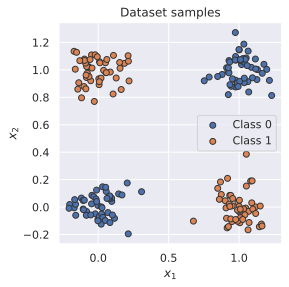

In [47]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity.
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `persistent_workers`: If True, workers will not be shutdown after an iteration over the dataset has finished. This can be useful if the time per epoch is small, or if you face issues with workers being killed during training.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.
* `collate_fn`: A function that defines how the elements per batch are combined. By default, PyTorch stacks them as PyTorch tensors. For JAX, we will change it to NumPy arrays.

Let's create a simple data loader below with a function that stacks batch elements as NumPy array instead of PyTorch Tensors:

In [48]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [49]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 1.0681953  -0.03102668]
 [ 0.7528356   0.9203105 ]
 [-0.10372461 -0.01903387]
 [ 0.01990597  0.9399783 ]
 [-0.11913035  0.06565536]
 [ 1.0173181   1.0385318 ]
 [ 0.9486133  -0.10592135]
 [-0.00626791  1.0955142 ]]
Data labels (8,) 
 [1 0 0 1 0 0 1 1]


### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in JAX and Flax. Now, we will look at step 3 and 5.

#### Stochastic Gradient Descent

For updating the parameters, Flax does not directly provide support for optimizers, but instead refers to another package called `optax` ([documentation](https://optax.readthedocs.io/en/latest/index.html)). Optax is an optimization library for JAX, which offers most common deep learning optimizers (SGD, Adam, Adagrad, RMSProp, etc.) and utilities (gradient clipping, weight decay, etc.).

In [50]:
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

For now, we will use the simplest optimizer, namely `optax.sgd`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1. Remember that we again aim to write functional code. Hence, the optimizer does not take as input the parameters, but only the optimizer hyperparameters.

In [51]:
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=0.1)

Since JAX calculates gradients via function transformations, we do not have functions like `backward()`, `optimizer.step()` or `optimizer.backward()` as in PyTorch. Instead, a optimizer is a function on the parameters and gradients. To simplify this step and bundle important parts of the training procedure, Flax offers the `flax.training` package. As a first step, we can create a `TrainState` which bundles the parameters, the optimizer, and the forward step of the model:

In [52]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

With this state object, it is easier to handle the training.

#### Loss function

For performing gradient updates, we need a function that can calculate the loss for a batch. Afterwards, we can apply JAX's gradient transformation to obtain a gradient function of it. In our setting, which is binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. Similar to PyTorch, Optax already provides a function for this: `optax.sigmoid_binary_cross_entropy(logits, labels)`. We calculate the loss on the logits instead of the sigmoid outputs for numerical stability. Let's write a function that takes as input a state (for the forward function), parameters, and a batch, and return the binary cross entropy loss and accuracy:

In [53]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

Note that we explicitly add the parameters here as an input argument since we want to calculate the gradients with respect to them later. An example execution of the function would look like:

In [54]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.6917485, dtype=float32), Array(0.25, dtype=float32))

### Creating an efficient training and validation step

With this loss function and the optimizer, we are now ready to create an efficient training and validation/test step. First, let's consider the training. As input to each training step, we have a training state and a batch. We then want to calculate the loss for the input and take the gradients of it. Finally, we update the parameters with our optimizer and return the new state. All this can be summarized in the following function:

In [55]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

By using the transformation `jax.jit`, the whole gradient calculation and application is optimized in XLA, providing an efficient function for updating the model.

Next, let's look at the evaluation function. Here, we do not need to calculate gradients, but only want to get the accuracy of the model for the batch. This becomes a simpler version of the training step:

In [56]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

These two functions provide us now efficient utilities to train our model.

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size.

In [57]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

Now, we can write a small training function. In contrast to PyTorch, we do not need to explicitly push our model to GPU, since the parameters are already automatically created on GPU. Further, since the model itself is stateless, we do not have a `train()` or `eval()` function to switch between modes of e.g. dropout. When necessary, we can add an argument `train : bool` to the model forward pass. For this simple network here, however, this is not necessary.

Following the PyTorch tutorial, let's write a function here that trains a model for several epochs:

In [58]:
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [59]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Training this model for 100 epochs does take barely a second... This shows the impressive speed JAX can reach, especially for small models!

#### Saving a model

After we finished training a model, we save the model to disk so that we can load the same weights at a later time. In JAX, this means we want to save the `state.params` dictionary. Luckily, the `flax.training` package again provides us with nice utilities for that, which uses TensorFlow as underlying framework.

In [60]:
from flax.training import checkpoints

To save the whole model state, we can write:

In [61]:
checkpoints.save_checkpoint(ckpt_dir='my_checkpoints/',  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

ValueError: Checkpoint path should be absolute. Got my_checkpoints/my_model100.orbax-checkpoint-tmp-0

To load this state dict again, we can use `checkpoints.restore_checkpoint`:

In [ ]:
loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir='my_checkpoints/',   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='my_model'  # Checkpoint file name prefix
                                            )

The states `loaded_model_state` and `trained_model_state` have the identical parameter values.

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [ ]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)

We can use our `eval_step` function to efficiently evaluate our model:

In [ ]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [ ]:
eval_model(trained_model_state, test_data_loader)

If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

#### Binding model parameters

Once we have trained the model, we might want to do multiple application of the same model and parameters. It can get a bit annoying to always write `model.apply(params, ...)` and keep track of the model and parameters separately. To prevent this, Flax's module can be bound to specific parameters to simplify our application. Specifically, we can bind the instance `model` of our `SimpleClassifier` class to our trained parameter as follows:

In [ ]:
trained_model = model.bind(trained_model_state.params)

With the model being binded to the parameters, we can use it as we would any PyTorch module. For instance, to apply it to an input array, we can simply run:

In [ ]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape

This can simplify the analysis of models, and provide a more familiar interface to PyTorch users.

#### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

In [ ]:
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()

The decision boundaries might not look exactly as in the figure in the preamble of this section, since this has been created with the PyTorch version of the tutorial. Nevertheless, the result on the accuracy metric should be the approximately the same.

### Conclusion

This concludes our tutorial on training a neural network with JAX. While the functional programming perspective of JAX may seem very different to PyTorch at first, it enables a considerable speedup in training, not only for tiny models like here. If you are interested in seeing more practical use cases of JAX, we recommend checking out our other JAX Tutorials, such as:

* [Tutorial 5 (JAX): Inception, ResNet and DenseNet](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html) gives an intro to training convolutional classifiers on CIFAR10;
* [Tutorial 6 (JAX): Transformers and Multi-Head Attention](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html) builds a Transformer from scratch with Flax;
* [Tutorial 7 (JAX): Graph Neural Networks](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial7/GNN_overview.html) implements basic Graph Neural Network layers;
* [Tutorial 9 (JAX): Deep Autoencoders](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial9/AE_CIFAR10.html) shows how to train autoencoders on CIFAR10;
* [Tutorial 11 (JAX): Normalizing Flows for image modeling](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial11/NF_image_modeling.html) discusses Normalizing Flows as generative model on images;
* [Tutorial 15 (JAX): Vision Transformers](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial15/Vision_Transformer.html) trains a Transformer on image classification for CIFAR10.

## ✨ The Fancy Bits ✨

After reading this tutorial, you might wonder why we left out some key advertisement points of JAX: automatic vectorization, easy parallelization on multiple accelerators, etc. The reason why we did not include them in our previous discuss is that for building simple networks, and actual most models in our tutorials, you do not really need these methods. However, since they can be handy at some times, for instance, if you have access to a large cluster or are faced with functions that are annoying to vectorize, we review them here in a separate section: the Fancy Bits of JAX (the title is inspired by JAX's tutorial [🔪 JAX - The Sharp Bits 🔪](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html)).

### Automatic Vectorization with vmap

In machine learning, we often vectorize methods to efficiently process multiple inputs or batch elements at the same time. Usually, we have to write the code ourselves to support additional dimensions to vectorize over. However, since JAX can already transform functions to run efficiently on accelerators or calculate gradients, it can also automatically vectorize a function. For instance, let's consider a simple linear layer where we write a function for a single input `x` of shape `[c_in]`, a weight matrix `[c_in, c_out]`, and a bias vector `[c_out]`:

In [ ]:
def simple_linear(x, w, b):
    # We could already vectorize this function with matmul, but as an example,
    # let us use a non-vectorized function with same output
    return (x[:,None] * w).sum(axis=0) + b

In [ ]:
# Example inputs
rng, x_rng, w_rng, b_rng = jax.random.split(rng, 4)
x_in = jax.random.normal(x_rng, (4,))
w_in = jax.random.normal(w_rng, (4, 3))
b_in = jax.random.normal(b_rng, (3,))

simple_linear(x_in, w_in, b_in)

Now, we would like the function to support a batch dimension on `x`, i.e. `[batch, c_in]`. Our naive implementation above does not support this, since we specialized the axis we sum over. So, let's make JAX do the work for us and vectorize the function by using `jax.vmap`:

In [ ]:
vectorized_linear = jax.vmap(simple_linear,
                             in_axes=(0, None, None),  # Which axes to vectorize for each input
                             out_axes=0  # Which axes to map to in the output
                            )

Specifying `None` for the in-axes of the input arguments `w` and `b` means that we do not want to vectorize any of their input dimensions. With this vmap specification, the function `vectorized_linear` now supports an extra batch dimension in `x`! Let's try it out:

In [ ]:
x_vec_in = jnp.stack([x_in]*5, axis=0)

vectorized_linear(x_vec_in, w_in, b_in)

The new function indeed vectorized our code, calculating $N$ applications of the weights and bias to the input. We can also vectorize the code to run multiple inputs `x` on multiple weights `w` and biases `b` by changing the input argument `in_axes` to `(0, 0, 0)`, or simply `0`. Morever, we can again stack multiple function transformations, such as jitting a vectorized function. Further details on `jax.vmap` can be found in this [tutorial](
https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html
) and its [documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html?highlight=vmap).

### Parallel evaluation with pmap

`jax.vmap` vectorizes a function on a single accelerator. But what if we have multiple GPUs or TPUs available? In PyTorch, we can parallelize a model over multiple GPUs using `nn.DistributedDataParallel`. In JAX, this is yet another function transformation: `jax.pmap`. Similar to `jax.vmap`, we can specify over which axes each input should be parallelized. In a network training, we usually want to parallelize over an extra batch dimension in the data, while the parameters are identical for all devices. For more details on `jax.pmap`, see [Parallel Evaluation in JAX](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html).

### Working with PyTrees

Network parameters in Flax are stored in a PyTree. We have visited them before, but what we haven't discuss yet is JAX's utilities to operate on pytrees! One common application is to obtain a list of all parameters in the network. This corresponds to extracting all leafs from a PyTree, for which JAX provides the function `jax.tree_leaves`:

In [ ]:
parameters = jax.tree_leaves(model_state.params)
print('We have parameters with the following shapes:', ', '.join([str(p.shape) for p in parameters]))
print('Overall parameter count:', sum([np.prod(p.shape) for p in parameters]))

We can also create new PyTrees that are the result of applying a function on all elements in the tree using `jax.tree_map`. For instance, let's obtain a PyTree with all parameter shapes:

In [ ]:
jax.tree_map(lambda p: p.shape, model_state.params)

The nodes of PyTrees do not necessarily need to be NumPy or JAX arrays, but can be arbitrary objects. Overall, PyTrees provide a simple, structured representation of data useful in many applications. More details can be found in JAX's Tutorial [Working with PyTrees](https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html).

## 🔪 The Sharp Bits 🔪

Since JAX functions need to be written with certain constraints, there are situations where this can get annoying or difficult. A great overview of those, why they are needed, and most importantly, what to do about them, can be found in the original JAX tutorial [🔪 JAX - The Sharp Bits 🔪](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html). In this final section of the tutorial, we want to visit a few of those points we have not explicitly discussed yet. Furthermore, we also focus on the combination with Flax, and what can be annoying when training models.

### Dynamic shapes

JAX has the great advantage of providing just-in-time compilation of functions to speed up the computation. For this, it uses its intermediate representation jaxpr, which is specialized to the shapes of the input arguments. However, this also means that a jitted function is specialized to a certain shape, and running the jitted function with a different input shape requires recompiling the function. For instance, consider the following simple function:

In [ ]:
def my_function(x):
    print('Running the function with shape', x.shape)
    return x.mean()

jitted_function = jax.jit(my_function)

The print statement is only executed once when the function is compiled, and for all consecutive function calls, this print statement will be ignored since it is not part of the jaxpr representation. Let's run the function now with multiple different input shapes:

In [ ]:
for i in range(10):
    jitted_function(jnp.zeros(i+1,))

As we can see, the function is compiled for every different input we give it. This can become inefficient if we actually work with many different shapes. However, running the function again with one of the previous input shapes will not require another compilation:

In [ ]:
# Running the functions a second time will not print out anything since
# the functions are already jitted for the respective input shapes.
for i in range(10):
    jitted_function(jnp.zeros(i+1,))

If we have a very limited set of different shapes, we do not see a big performance difference. For instance, in our evaluation, the last batch size is smaller than the previous since we have a limited size of the evaluation dataset. However, for other applications, we might encounter this problem much more often: NLP and time series, and graphs. In these cases, it is recommend to pad the batches to prevent many re-compilations (see Flax's [padding guide](https://flax.readthedocs.io/en/latest/howtos/full_eval.html) for details). We briefly review the two scenarios below.

#### NLP and time series

In Natural Language Processing, our data consist of sentences which greatly vary in size. Already for batching the elements, we need to apply padding, such that the shape of the batch is determined by the largest sentence in the batch. However, this largest length can vary between batches, especially when we shuffle the dataset before each epoch. In PyTorch, this is not a problem, since the dynamic computation graph allows us to stop the computation whenever we need to. In contrast, JAX would need to recompile the forward pass for every single largest sentence length, which can quickly become very expensive. Padding is needed to reduce the number of compilations, but at the same time introduces unnecessary computation. Hence, we have a tradeoff between number of compilations and extra compute per batch. In the extreme case, PyTorch may even become faster than JAX here.

#### Graphs

Similar to NLP, graphs can vary in their size. Often, graphs differ in their number of nodes, but especially in the number of edges. Furthermore, when we start batching the graphs, the variation of node sizes and edge count considerably increases. Again, padding is needed to reduce the number of compilations, and we will revisit this topic in Tutorial 7 (TBD).

### Debugging in jitted functions

During coding, we likely want to debug our model and sometimes print out intermediate values. In JAX, when jitting functions, this is not as straightforward. As we could see from the previous cells, a print statement is only executed once during compilation, and afterwards removed since it is not part of the jaxpr representation. Furthermore, there can be issues when tracking NaNs in your code (see the [sharp bits tutorial](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#debugging-nans)), and errors like out-of-bounds indexing are silently handled on accelerators by returning -1 instead of an error (see the corresponding section in the [sharp bits tutorial](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#out-of-bounds-indexing)). However, if necessary, one can either run the unjitted version of the forward pass first, and even introduce print statements to the jitted version where needed (see [here](https://github.com/google/jax/issues/196) for a great explanation). Still, it is not as straight-forward as in PyTorch, for example.

### Modules with different train and evaluation functions

Certain deep learning layers have different behaviors under evaluation than during training. For instance, dropout randomly masks out a number of neurons during training, but leaves the graph untouched during evaluation. In PyTorch, we can easily switch between the two states via `model.train()` and `model.eval()` without having to manually specify it in the dropout module instance. However, in JAX, we do not have global states in the model, and thus need to pass this information to every module in the forward pass that may need it. In our example above, this was not needed, since the forward pass of the simple classifier is identical during training and evaluation. Alternatively, since the parameters are not bound to a specific model during training, one can also create two models: one training model, and one evaluation model. Nonetheless, one still needs to add the information to every module with changing behaviors, which adds a certain overhead compared to PyTorch. We will discuss two common modules with such behaviors below: dropout and BatchNorm.

#### Dropout

In Flax, [Dropout](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.Dropout.html) has an argument `deterministic` which turns off dropout when True, and otherwise applies the random masking as intended during training. This deterministic switch can either be defined in the constructor, or in every forward call. Furthermore, dropout has the special case that it is a random operation during training, meaning that it also needs a PRNG state. Fortunately, we do not have to pass this state in every PRNG state, but instead, can simply pass `rngs={'dropout': dropout_rng}` with `dropout_rng` being the PRNG state. For an example, see our [Tutorial 6](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html) on Transformers in which we use dropout in several occasions.

#### BatchNorm

Batch Normalization transforms the input in two different ways. During training, we determine the mean and standard deviation of the input, and normalize the data with it to a zero mean and standard deviation of one. During evaluation, on the other hand, we take a running statistic over the previous several batches, and use those to estimate the mean and standard deviation. This is necessary to keep the evaluation stable and invariant to the specific batches we choose. Still, in the Flax module ([documentation](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.BatchNorm.html)), we need to give the argument `use_running_average` (bool) to either the constructor or each forward pass. Furthermore, BatchNorm has a specific property we haven't discussed yet and is a bit tricky in JAX: keeping track of the running average. During every forward pass, we want to record the mean and standard deviation of the current batch, and update our current average over the past batches. However, this requires changing an input tensor, and returning this changed tensor again. In Flax, we can do this by defining the batch statistics as a mutable tensor. Check out our [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html) to see BatchNorm being used in practice with Flax.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub.

---